In [50]:
from copy import copy
from itertools import combinations

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

from scipy.stats import mannwhitneyu

sns.set_theme()
warnings.filterwarnings('ignore')

In [51]:
problems = ["chemical_1_tower", "chemical_2_competition", "friction_dyn_one-hot", "friction_stat_one-hot",
            "nasa_battery_1_10min", "nasa_battery_2_20min", "nikuradse_1", "nikuradse_2", "flow_stress_phip0.1", ]

In [52]:
dfs = []
missing = 0
missing_configs = []
for w in ["win", "wfn", "win_bin", "wfn_bin", "win_bfn", "wfn_bfn", "no"]:
    for problem in problems:
        for seed in range(30):
            for opt in ["adam", "gaussian"]:
                w_text = f"{w}_" if "w" in w else ""
                if os.path.exists(f"../results/ga2_{problem}_{opt}_{w_text}{seed}.pickle"):
                    tmp_df = pd.read_csv(f"../results/ga2_{problem}_{opt}_{w_text}{seed}.csv")
                    tmp_df["seed"] = seed
                    tmp_df["w"] = w
                    tmp_df["opt"] = opt
                    tmp_df["problem"] = problem
                    tmp_df["total_time"] = tmp_df["time"].cumsum().astype(int)
                    dfs.append(tmp_df)
                else:
                    if "w" in w:
                        missing += 1
                        missing_configs.append([seed, w, problem])
                    continue
df = pd.concat(dfs, ignore_index=True)
df["test_accuracy"] = df["test_accuracy"].str.replace(r"[\[\]]", "", regex=True).astype(float)
df.head()

,iteration,max_fitness,time,test_accuracy,seed,w,opt,problem,total_time
0,0,-3.591574,0.000000,-4.37319,0,win,adam,chemical_1_tower,0
1,1,-3.345382,16.725472,-4.37319,0,win,adam,chemical_1_tower,16
2,2,-3.046887,16.692033,-4.37319,0,win,adam,chemical_1_tower,33
3,3,-3.509441,16.876105,-4.37319,0,win,adam,chemical_1_tower,50
4,4,-3.620439,16.455559,-4.37319,0,win,adam,chemical_1_tower,66


In [53]:
missing

157

In [23]:
max_iter = (
    df.groupby(["problem", "opt"])["iteration"]
    .max()
    .unstack()
)
max_iter["adam_iteration_multiplier"] = max_iter["gaussian"] / max_iter["adam"]
result = max_iter.reset_index()
df = df.merge(
    result[["problem", "adam_iteration_multiplier"]],
    on="problem",
    how="left"
)
df["adjusted_iteration"] = np.where(
    df["opt"] == "adam",
    df["iteration"] * df["adam_iteration_multiplier"],
    df["iteration"]
)
df.head()

,iteration,max_fitness,time,test_accuracy,seed,w,opt,problem,total_time,adam_iteration_multiplier,adjusted_iteration
0,0,-3.591574,0.000000,-4.37319,0,win,adam,chemical_1_tower,0,2.566781,0.000000
1,1,-3.345382,16.725472,-4.37319,0,win,adam,chemical_1_tower,16,2.566781,2.566781
2,2,-3.046887,16.692033,-4.37319,0,win,adam,chemical_1_tower,33,2.566781,5.133562
3,3,-3.509441,16.876105,-4.37319,0,win,adam,chemical_1_tower,50,2.566781,7.700342
4,4,-3.620439,16.455559,-4.37319,0,win,adam,chemical_1_tower,66,2.566781,10.267123


In [24]:
baselines_list = ["Operon", "QLattice", "PySR", "eggp"]
# baselines_list = ["Operon"]
baselines_df = pd.read_csv("baselines.csv")
baselines_df.rename(columns={
    "run": "seed",
    "algorithm": "opt",
    "r2_test": "accuracy",
    "dataset": "problem",
}, inplace=True)
baselines_df = baselines_df[["seed", "opt", "accuracy", "problem"]]
baselines_df = baselines_df[baselines_df["opt"].isin(baselines_list)]
baselines_df = baselines_df[baselines_df["problem"].isin(problems)]
baselines_df["w"] = "no"
baselines_df.head()

,seed,opt,accuracy,problem,w
4696,0,eggp,0.876939,chemical_1_tower,no
4697,1,eggp,0.857567,chemical_1_tower,no
4698,2,eggp,0.868668,chemical_1_tower,no
4699,3,eggp,0.829023,chemical_1_tower,no
4700,4,eggp,0.840139,chemical_1_tower,no


In [25]:
df1 = copy(df)
df2 = copy(df)
df1 = df.rename(columns={"test_accuracy": "accuracy"})
df2 = df.rename(columns={"max_fitness": "accuracy"})
df1 = df1.drop(columns=["max_fitness"])
df2 = df2.drop(columns=["test_accuracy"])
df1["when"] = "test"
df2["when"] = "train"
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,iteration,time,accuracy,seed,w,opt,problem,total_time,adam_iteration_multiplier,adjusted_iteration,when
0,0,0.000000,-4.37319,0,win,adam,chemical_1_tower,0,2.566781,0.000000,test
1,1,16.725472,-4.37319,0,win,adam,chemical_1_tower,16,2.566781,2.566781,test
2,2,16.692033,-4.37319,0,win,adam,chemical_1_tower,33,2.566781,5.133562,test
3,3,16.876105,-4.37319,0,win,adam,chemical_1_tower,50,2.566781,7.700342,test
4,4,16.455559,-4.37319,0,win,adam,chemical_1_tower,66,2.566781,10.267123,test


In [26]:
max_iter = df.groupby(["opt", "problem"])["iteration"].transform("max")
final_df = df[df["iteration"] == max_iter].reset_index(drop=True)
final_df.head()

,iteration,time,accuracy,seed,w,opt,problem,total_time,adam_iteration_multiplier,adjusted_iteration,when
0,584,16.919471,0.839344,0,win,adam,chemical_1_tower,9959,2.566781,1499.0,test
1,1499,2.746425,0.489220,0,win,gaussian,chemical_1_tower,4298,2.566781,1499.0,test
2,584,17.071883,0.674324,1,win,adam,chemical_1_tower,9924,2.566781,1499.0,test
3,1499,2.771516,0.802236,1,win,gaussian,chemical_1_tower,4285,2.566781,1499.0,test
4,584,16.854705,0.812983,2,win,adam,chemical_1_tower,9885,2.566781,1499.0,test


In [27]:
reopt_dfs = []
missing = 0
for w in ["win", "wfn", "win_bin", "wfn_bin", "win_bfn", "wfn_bfn", "no"]:
    for problem in problems:
        for seed in range(30):
            for reopt in ["adam", ]:
                for opt in ["adam", "gaussian", "none"]:
                    try:
                        tmp_df = pd.read_csv(f"../results/ga3_{problem}_{opt}_{w}_reopt-{reopt}_{seed}.csv")
                        tmp_df["seed"] = seed
                        tmp_df["w"] = w if len(w) > 0 else "no w"
                        tmp_df["opt"] = opt if opt != "none" else "CGP"
                        tmp_df["reopt"] = reopt
                        tmp_df["problem"] = problem
                        reopt_dfs.append(tmp_df)
                    except FileNotFoundError:
                        missing += 1
                        pass
reopt_df = pd.concat(reopt_dfs, ignore_index=True)
reopt_df["test_increase"] = reopt_df["test_accuracy"] - reopt_df["previous_test_accuracy"]
reopt_df["train_increase"] = reopt_df["max_fitness"] - reopt_df["previous_max_fitness"]
reopt_df["equation"] = reopt_df["equation"].str.replace("<lambda>", "", regex=False)
reopt_df.head()

,iteration,time,max_fitness,test_accuracy,previous_max_fitness,previous_test_accuracy,equation,seed,w,opt,reopt,problem,test_increase,train_increase
0,0,194.660743,0.839458,0.839344,0.839458,0.839344,o0 = ((-0.97*(-0.27*(0.04*(0.17*i1*0.40*i21)-0...,0,win,adam,adam,chemical_1_tower,0.000000,0.000000
1,0,119.438212,0.472530,0.487041,0.472454,0.485554,o0 = ((-0.42*(0.61*abs(-1.47*i21)-0.11*i5)--1....,0,win,gaussian,adam,chemical_1_tower,0.001487,0.000075
2,0,154.413757,0.608548,0.622315,0.592760,0.607127,o0 = ((1.03*sqrt(1.03*pow(1.04*i9))+1.02*(0.99...,0,win,CGP,adam,chemical_1_tower,0.015188,0.015787
3,0,194.586228,0.667210,0.675796,0.667259,0.673817,o0 = ((-0.31*(-0.59*(0.50*(0.40*i1--1.15*i20)-...,1,win,adam,adam,chemical_1_tower,0.001980,-0.000049
4,0,119.870111,0.792544,0.801759,0.793436,0.802236,o0 = (abs(1.57*(0.94*(0.76*sqrt(-0.73*(-1.81*i...,1,win,gaussian,adam,chemical_1_tower,-0.000477,-0.000892


In [28]:
missing

1031

In [29]:
# reopt_df.drop(columns=['iteration']).to_csv("equations.csv")

In [30]:
# sns.relplot(data=df[df["when"] == "train"], x="adjusted_iteration", y="accuracy", hue="opt", col="w",
#             row="problem", errorbar="sd", kind="line", palette="Set1")
# plt.ylim(-.1, 1.1)
# plt.show()

In [31]:
# sns.relplot(data=df[df["when"] == "test"], x="adjusted_iteration", y="accuracy", hue="opt", col="w",
#             row="problem", errorbar="sd", kind="line", palette="Set1")
# plt.ylim(-.1, 1.1)
# plt.show()

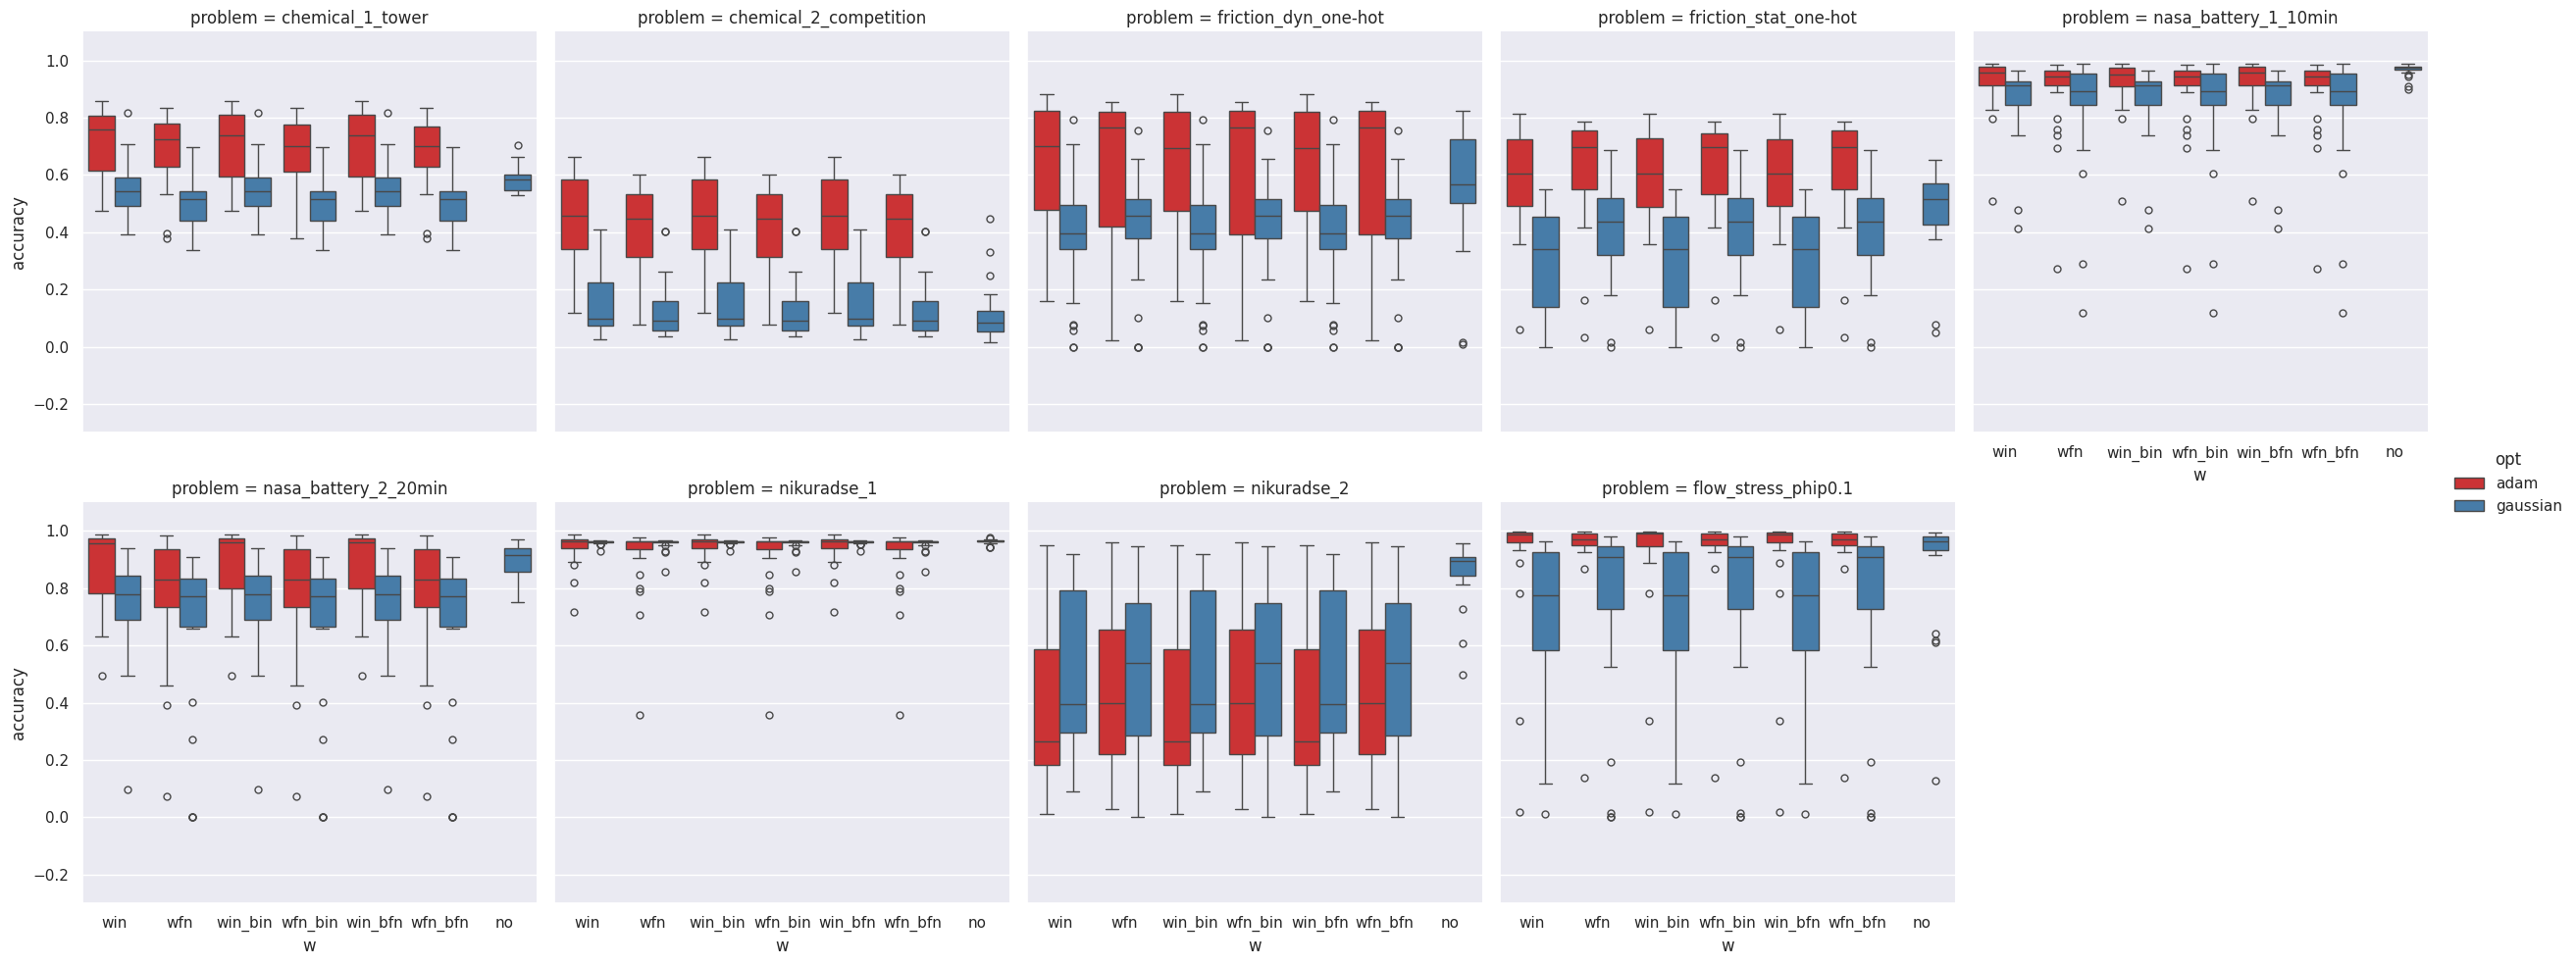

In [32]:
sns.catplot(x="w", y="accuracy", hue="opt", data=final_df[final_df["when"] == "train"], col_wrap=5,  # row="when",
            col="problem", kind="box", palette="Set1")
plt.ylim(-.3, 1.1)
plt.show()

In [33]:
final_df_for_baseline_merge = final_df[final_df["when"] == "test"][["seed", "w", "opt", "problem", "accuracy"]]
baselines_df_filtered = baselines_df[baselines_df["problem"].isin(final_df_for_baseline_merge["problem"])]
final_df_and_baseline = pd.concat([final_df_for_baseline_merge, baselines_df_filtered], ignore_index=True)
final_df_and_baseline.head()

,seed,w,opt,problem,accuracy
0,0,win,adam,chemical_1_tower,0.839344
1,0,win,gaussian,chemical_1_tower,0.489220
2,1,win,adam,chemical_1_tower,0.674324
3,1,win,gaussian,chemical_1_tower,0.802236
4,2,win,adam,chemical_1_tower,0.812983


In [34]:
reopt_df_for_baseline_merge = reopt_df[["seed", "w", "opt", "reopt", "problem", "test_accuracy"]]
reopt_df_for_baseline_merge.rename(columns={"test_accuracy": "accuracy"}, inplace=True)
# baselines_df.rename(columns={"opt": "reopt"}, inplace=True)
baselines_df["reopt"] = "none"
final_df_and_baseline.loc[
    (final_df_and_baseline["w"] == "no") & (final_df_and_baseline["opt"] == "gaussian"),
    "opt"
] = "CGP"
reopt_df_and_baseline = pd.concat([reopt_df_for_baseline_merge, baselines_df], ignore_index=True)

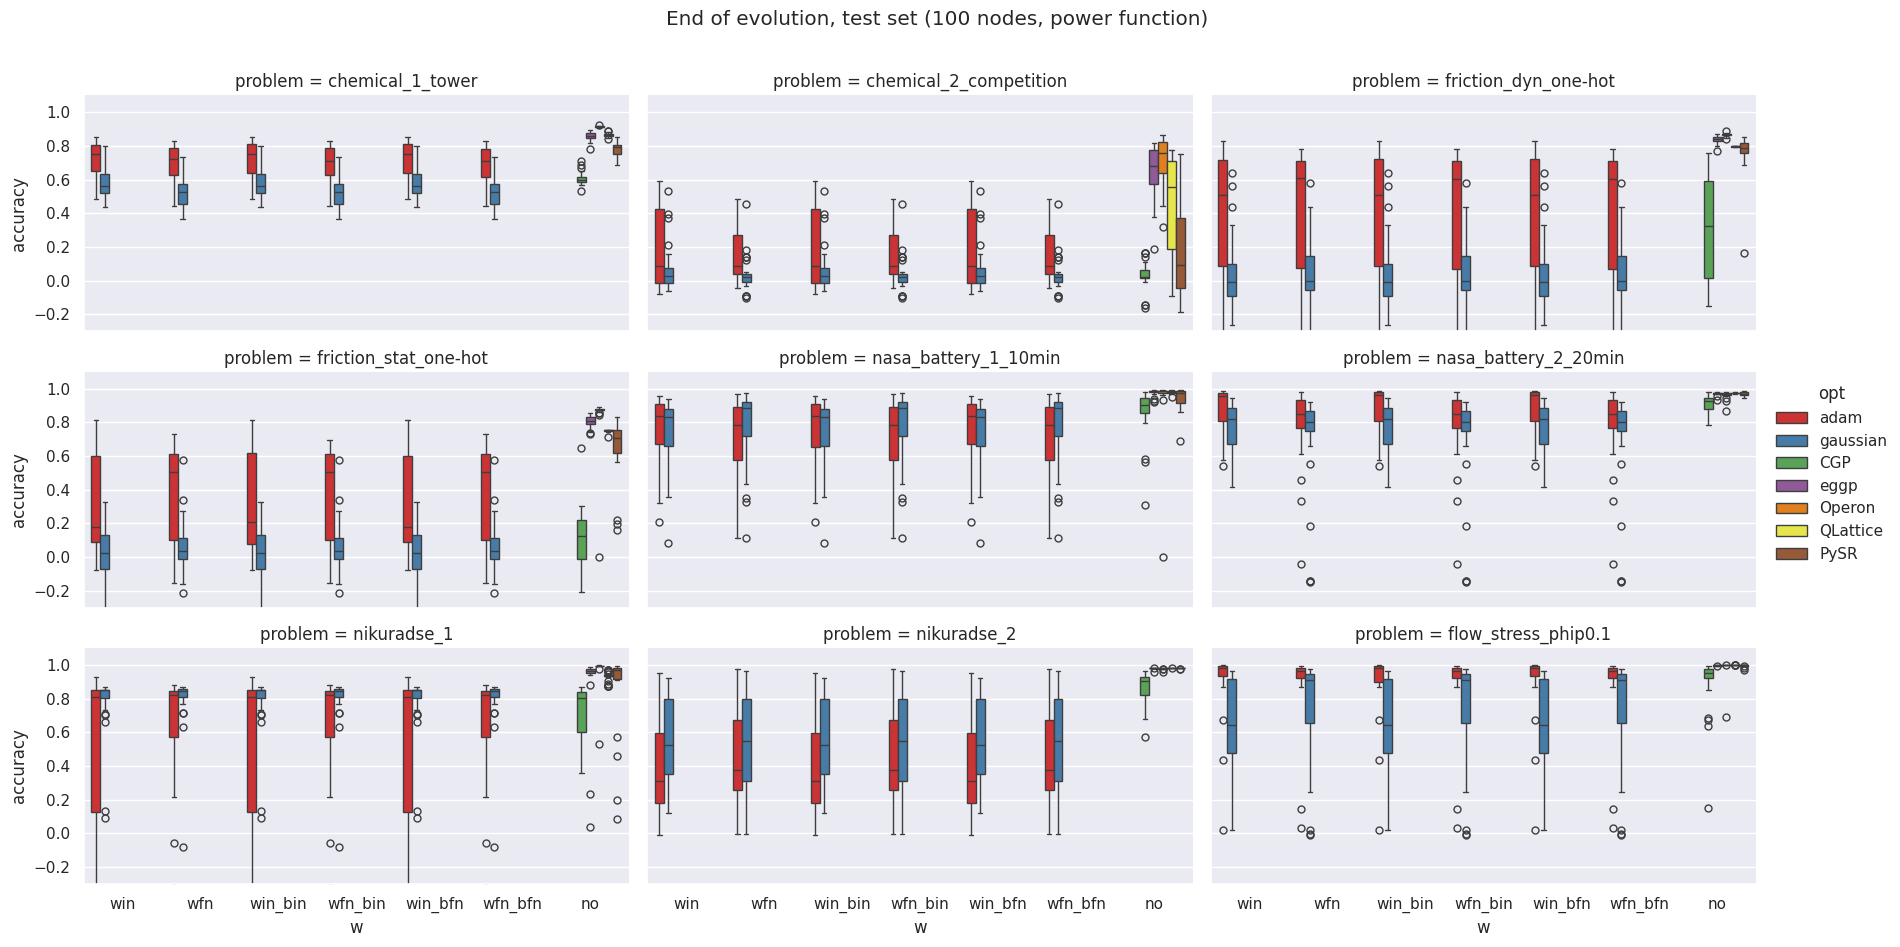

In [35]:
g = sns.catplot(x="w", y="accuracy", hue="opt", data=final_df_and_baseline, col="problem", col_wrap=3,
                kind="box", palette="Set1", height=3, aspect=2)
g.figure.suptitle("End of evolution, test set (100 nodes, power function)", y=1.05)  # Add title above the plot
plt.ylim(-.3, 1.1)
plt.show()

In [36]:
# g = sns.catplot(data=reopt_df, x="w", y="max_fitness", hue="opt", col="problem", kind="box", palette="Set1", col_wrap=5)
# plt.ylim(-.3, 1.1)
# plt.show()

In [37]:
# sns.catplot(data=reopt_df, x="w", y="test_accuracy", hue="opt", col="problem", kind="box", palette="Set1", col_wrap=5)
# plt.ylim(-.3, 1.1)
# plt.show()

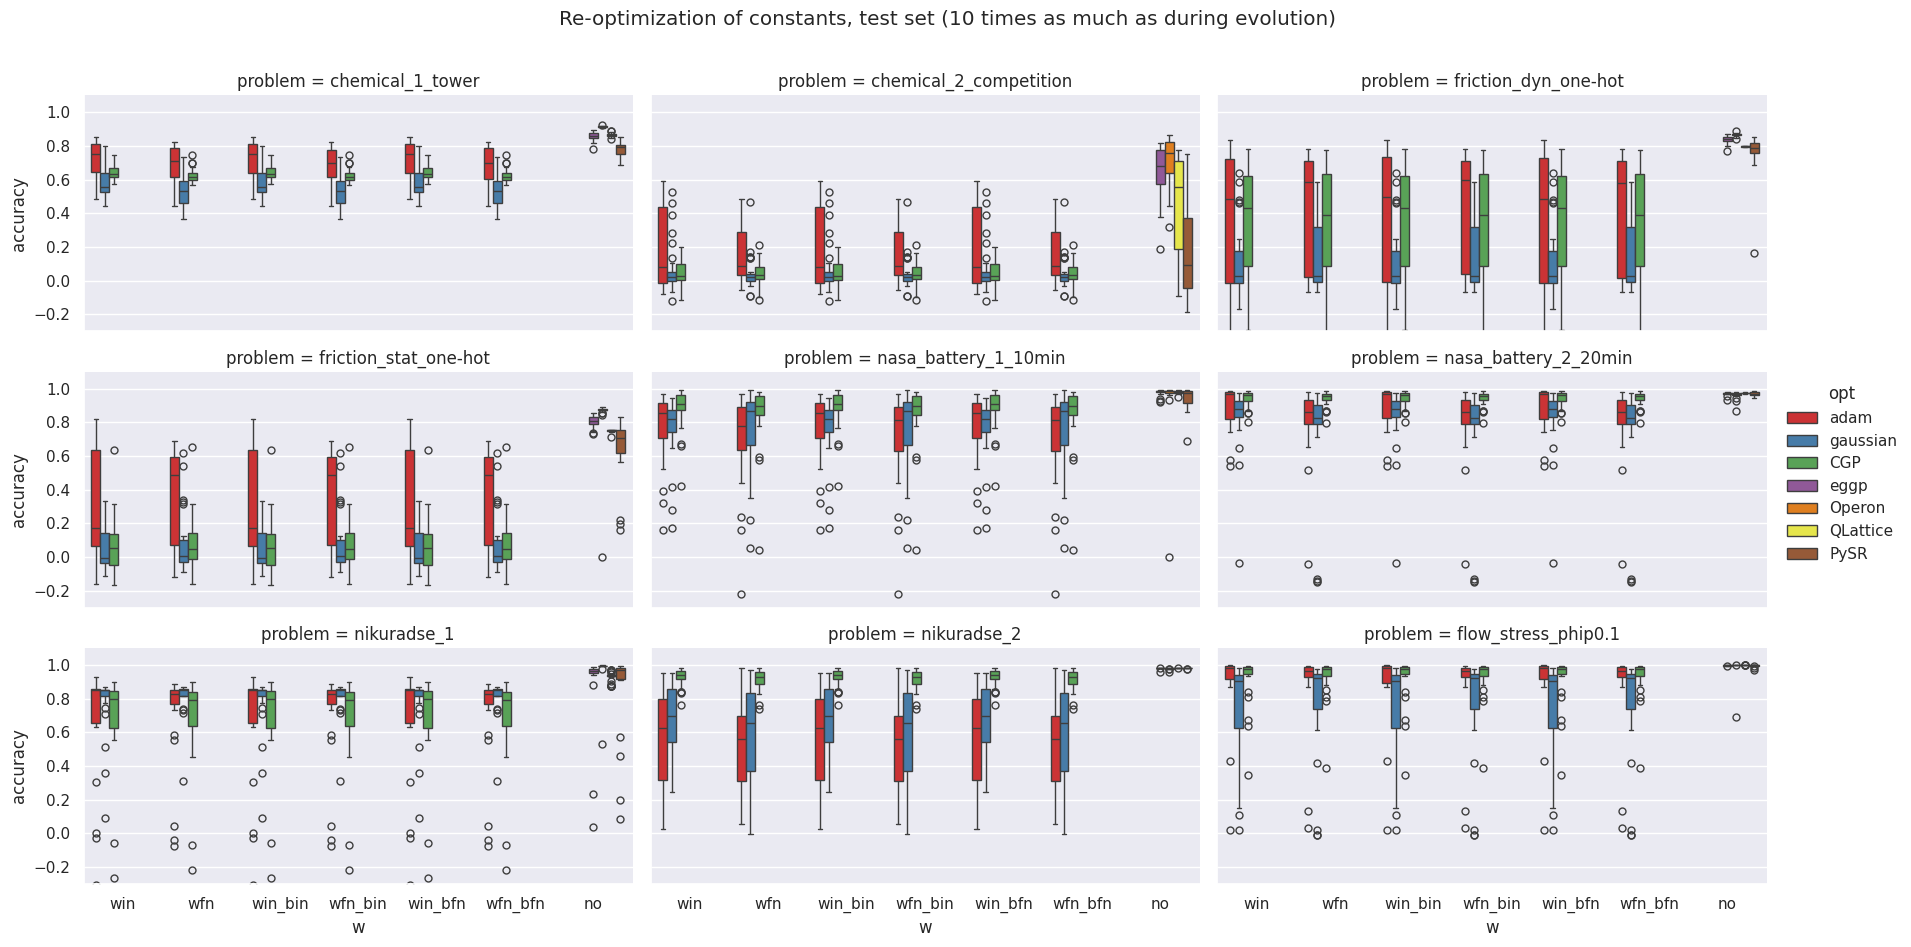

In [38]:
g = sns.catplot(data=reopt_df_and_baseline, x="w", y="accuracy", hue="opt", col="problem", kind="box", palette="Set1",
                col_wrap=3, height=3, aspect=2)
g.figure.suptitle("Re-optimization of constants, test set (10 times as much as during evolution)",
                  y=1.05)  # Add title above the plot
plt.ylim(-.3, 1.1)
plt.show()

In [39]:
fb_final = final_df_and_baseline.copy()
fb_final["reopt"] = "N"
reopt_df_for_baseline_merge["reopt"] = "Y"
super_final_df = pd.concat([fb_final, reopt_df_for_baseline_merge], ignore_index=True)
super_final_df["w_reopt"] = super_final_df["w"].astype(str) + " " + super_final_df["reopt"].astype(str)
w_order = sorted(super_final_df["w"].unique())
reopt_order = sorted(super_final_df["reopt"].unique())
combined_order = [f"{w} {r}" for w in w_order for r in reopt_order if f"{w} {r}" in super_final_df["w_reopt"].values]
super_final_df["w_reopt"] = pd.Categorical(super_final_df["w_reopt"], categories=combined_order, ordered=True)
super_final_df.head()

,seed,w,opt,problem,accuracy,reopt,w_reopt
0,0,win,adam,chemical_1_tower,0.839344,N,win N
1,0,win,gaussian,chemical_1_tower,0.489220,N,win N
2,1,win,adam,chemical_1_tower,0.674324,N,win N
3,1,win,gaussian,chemical_1_tower,0.802236,N,win N
4,2,win,adam,chemical_1_tower,0.812983,N,win N


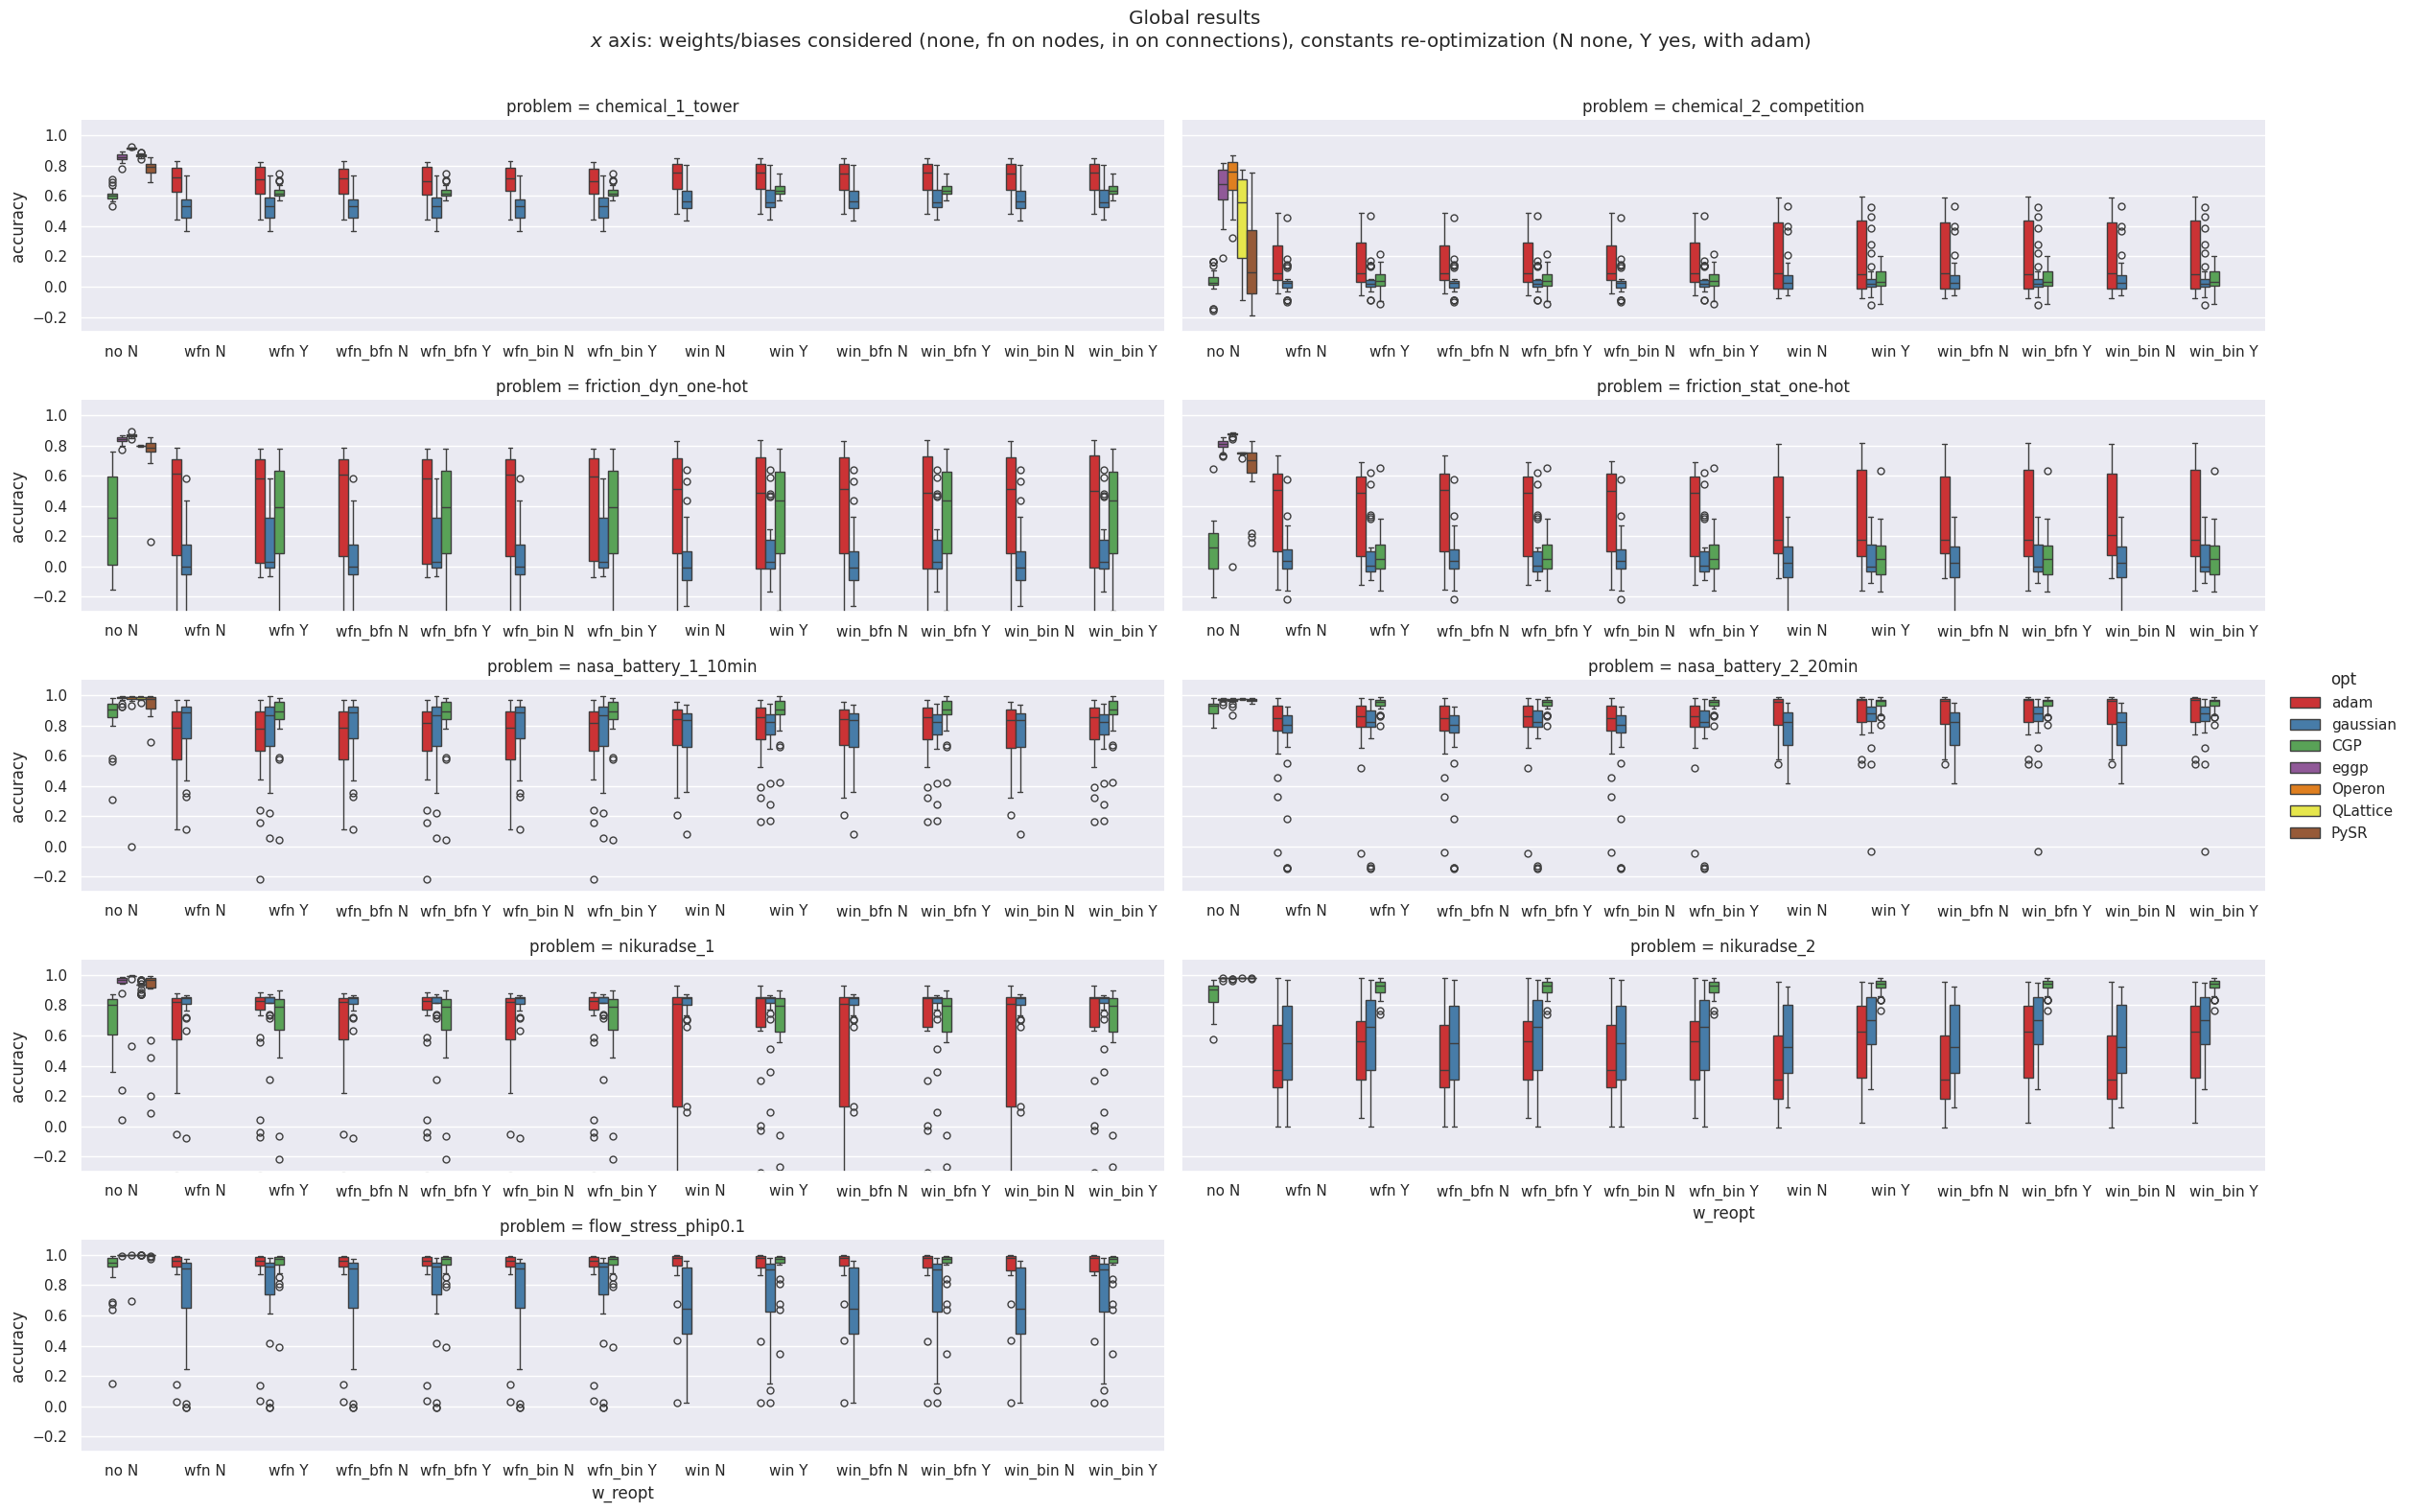

In [40]:
g = sns.catplot(data=super_final_df, x="w_reopt", y="accuracy", hue="opt", col="problem", kind="box", palette="Set1",
                col_wrap=2, height=3, aspect=4, sharex=False, )
g.figure.suptitle(
    "Global results \n $x$ axis: weights/biases considered (none, fn on nodes, in on connections), constants re-optimization (N none, Y yes, with adam)",
    y=1.05)
plt.ylim(-.3, 1.1)
plt.show()

In [41]:
median_final_df = \
    final_df_and_baseline[final_df_and_baseline["opt"].isin(["gaussian", "adam", "CGP", "Operon"])].groupby(
        ['opt', 'w', 'problem'])['accuracy'].median().reset_index()
median_final_df = median_final_df.rename(columns={"accuracy": "median_accuracy"})
best_configs_final_df = median_final_df.loc[median_final_df.groupby(['problem', 'opt'])["median_accuracy"].idxmax()]
final_df_for_stat_tests = final_df_and_baseline.merge(
    best_configs_final_df,
    on=["opt", "problem", "w"],
    how="inner"
)
final_df_for_stat_tests.head()

,seed,w,opt,problem,accuracy,median_accuracy
0,0,win,adam,chemical_1_tower,0.839344,0.754616
1,0,win,gaussian,chemical_1_tower,0.489220,0.562652
2,1,win,adam,chemical_1_tower,0.674324,0.754616
3,1,win,gaussian,chemical_1_tower,0.802236,0.562652
4,2,win,adam,chemical_1_tower,0.812983,0.754616


In [42]:
# for each problem in reopt (then we should also do opt)
# operon, best gaussian -> adam, best adam -> adam, CGP
# stat test (give warning if not at least 10 reps)
final_reopt_stat = super_final_df[
    (
            (super_final_df["opt"].isin(["adam", "gaussian", "CGP"])) &
            (super_final_df["reopt"] == "Y")
    ) |
    (
            (super_final_df["opt"].isin(["Operon", "CGP"])) &
            (super_final_df["reopt"] == "N")
    )
    ]
median_final_reopt = final_reopt_stat.groupby(['opt', 'reopt', 'w', 'problem'])['accuracy'].median().reset_index()
median_final_reopt = median_final_reopt.rename(columns={"accuracy": "median_accuracy"})
best_configs_reopt_df = median_final_reopt.loc[
    median_final_reopt.groupby(['problem', 'opt', 'reopt'])['median_accuracy'].idxmax()]
reopt_df_for_stat_tests = final_reopt_stat.merge(
    best_configs_reopt_df,
    on=["opt", "problem", "w", "reopt"],
    how="inner"
)
mask = (reopt_df_for_stat_tests["opt"] == "CGP") & (reopt_df_for_stat_tests["reopt"] == "Y")
reopt_df_for_stat_tests.loc[mask, "opt"] = "CGP+const"
reopt_df_for_stat_tests.head()

,seed,w,opt,problem,accuracy,reopt,w_reopt,median_accuracy
0,0,no,CGP,chemical_1_tower,0.607127,N,no N,0.599421
1,1,no,CGP,chemical_1_tower,0.595511,N,no N,0.599421
2,2,no,CGP,chemical_1_tower,0.535032,N,no N,0.599421
3,3,no,CGP,chemical_1_tower,0.583234,N,no N,0.599421
4,4,no,CGP,chemical_1_tower,0.599222,N,no N,0.599421


In [43]:
def pairwise_tests_for_problem(df_problem):
    opts = df_problem["opt"].unique()
    pvals = pd.DataFrame(
        np.ones((len(opts), len(opts))),
        index=opts,
        columns=opts
    )

    for opt1, opt2 in combinations(opts, 2):
        x = df_problem[df_problem["opt"] == opt1]["accuracy"]
        y = df_problem[df_problem["opt"] == opt2]["accuracy"]

        # Mann–Whitney U test
        stat, p = mannwhitneyu(x, y, alternative="two-sided")

        pvals.loc[opt1, opt2] = p
        pvals.loc[opt2, opt1] = p

    np.fill_diagonal(pvals.values, np.nan)
    return pvals

In [44]:
pval_tables_final = {}
pval_tables_reopt = {}

for problem, df_p in final_df_for_stat_tests.groupby("problem"):
    pval_tables_final[problem] = pairwise_tests_for_problem(df_p)
for problem, df_p in reopt_df_for_stat_tests.groupby("problem"):
    pval_tables_reopt[problem] = pairwise_tests_for_problem(df_p)

In [45]:
median_lookup_final = (
    final_df_for_stat_tests.groupby(["problem", "opt"])["median_accuracy"]
    .first()
)
median_lookup_reopt = (
    reopt_df_for_stat_tests.groupby(["problem", "opt"])["median_accuracy"]
    .first()
)

In [46]:
from matplotlib import colors, cm


def plot_pval_table(problem, pvals, median_lookup):
    opts = pvals.index

    # median accuracies
    medians = median_lookup.loc[problem, opts]

    # normalize colors (higher = better)
    norm = colors.Normalize(vmin=medians.min(), vmax=medians.max())
    cmap = cm.get_cmap("viridis")

    # plot heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        pvals,
        annot=True,
        fmt=".2e",
        cmap="coolwarm_r",
        cbar_kws={"label": "p-value"},
        square=True
    )

    # color row/column labels
    for label in ax.get_xticklabels():
        opt = label.get_text()
        label.set_color(cmap(norm(medians[opt])))

    for label in ax.get_yticklabels():
        opt = label.get_text()
        label.set_color(cmap(norm(medians[opt])))

    ax.set_title(f"Pairwise statistical tests – {problem}")
    plt.tight_layout()
    plt.show()

In [47]:
def plot_all_problems_3x3(pval_tables, median_lookup, figure_title):
    problems = list(pval_tables.keys())
    assert len(problems) == 9, "Expected exactly 9 problems"

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

    for ax, problem in zip(axes, problems):
        pvals = pval_tables[problem]
        opts = pvals.index

        # median accuracies for header coloring
        # medians = median_lookup.loc[problem, opts]
        medians = (
            median_lookup
            .loc[problem]  # slice by problem
            .reindex(opts)  # ensure same opt order
        )

        norm = colors.Normalize(vmin=medians.min(), vmax=medians.max())
        cmap_headers = cm.get_cmap("Blues")

        # draw table-like heatmap with no color
        sns.heatmap(
            pvals,
            annot=True,
            fmt=".2e",
            cmap=[[1, 1, 1]],  # force white cells
            cbar=False,
            square=True,
            linewidths=0.5,
            linecolor="black",
            ax=ax,
            annot_kws={"fontsize": 9 if len(pvals) > 4 else 12}
        )

        ax.set_title(problem)

        # color row/column labels by median accuracy
        # for label in ax.get_xticklabels():
        #     opt = label.get_text()
        #     label.set_color(cmap_headers(norm(medians[opt])))
        #
        # for label in ax.get_yticklabels():
        #     opt = label.get_text()
        #     label.set_color(cmap_headers(norm(medians[opt])))
        for label in ax.get_xticklabels():
            opt = label.get_text()
            label.set_color("black")
            label.set_bbox(dict(
                facecolor=cmap_headers(norm(medians[opt])),
                edgecolor="none",
                boxstyle="round,pad=0.25"
            ))

        for label in ax.get_yticklabels():
            opt = label.get_text()
            label.set_color("black")
            label.set_bbox(dict(
                facecolor=cmap_headers(norm(medians[opt])),
                edgecolor="none",
                boxstyle="round,pad=0.25"
            ))

    # remove unused axes (if any)
    for ax in axes[len(problems):]:
        ax.axis("off")

    # add horizontal colorbar **higher above the figure**
    sm = plt.cm.ScalarMappable(cmap=cmap_headers, norm=norm)
    sm.set_array([])

    # [left, bottom, width, height] — move bottom higher, shrink width if needed
    cbar_ax = fig.add_axes([0.15, 1.01, 0.7, 0.03])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Median Accuracy (header color)")

    fig.suptitle(figure_title, fontsize=16, y=1.08)

    plt.tight_layout()
    plt.show()

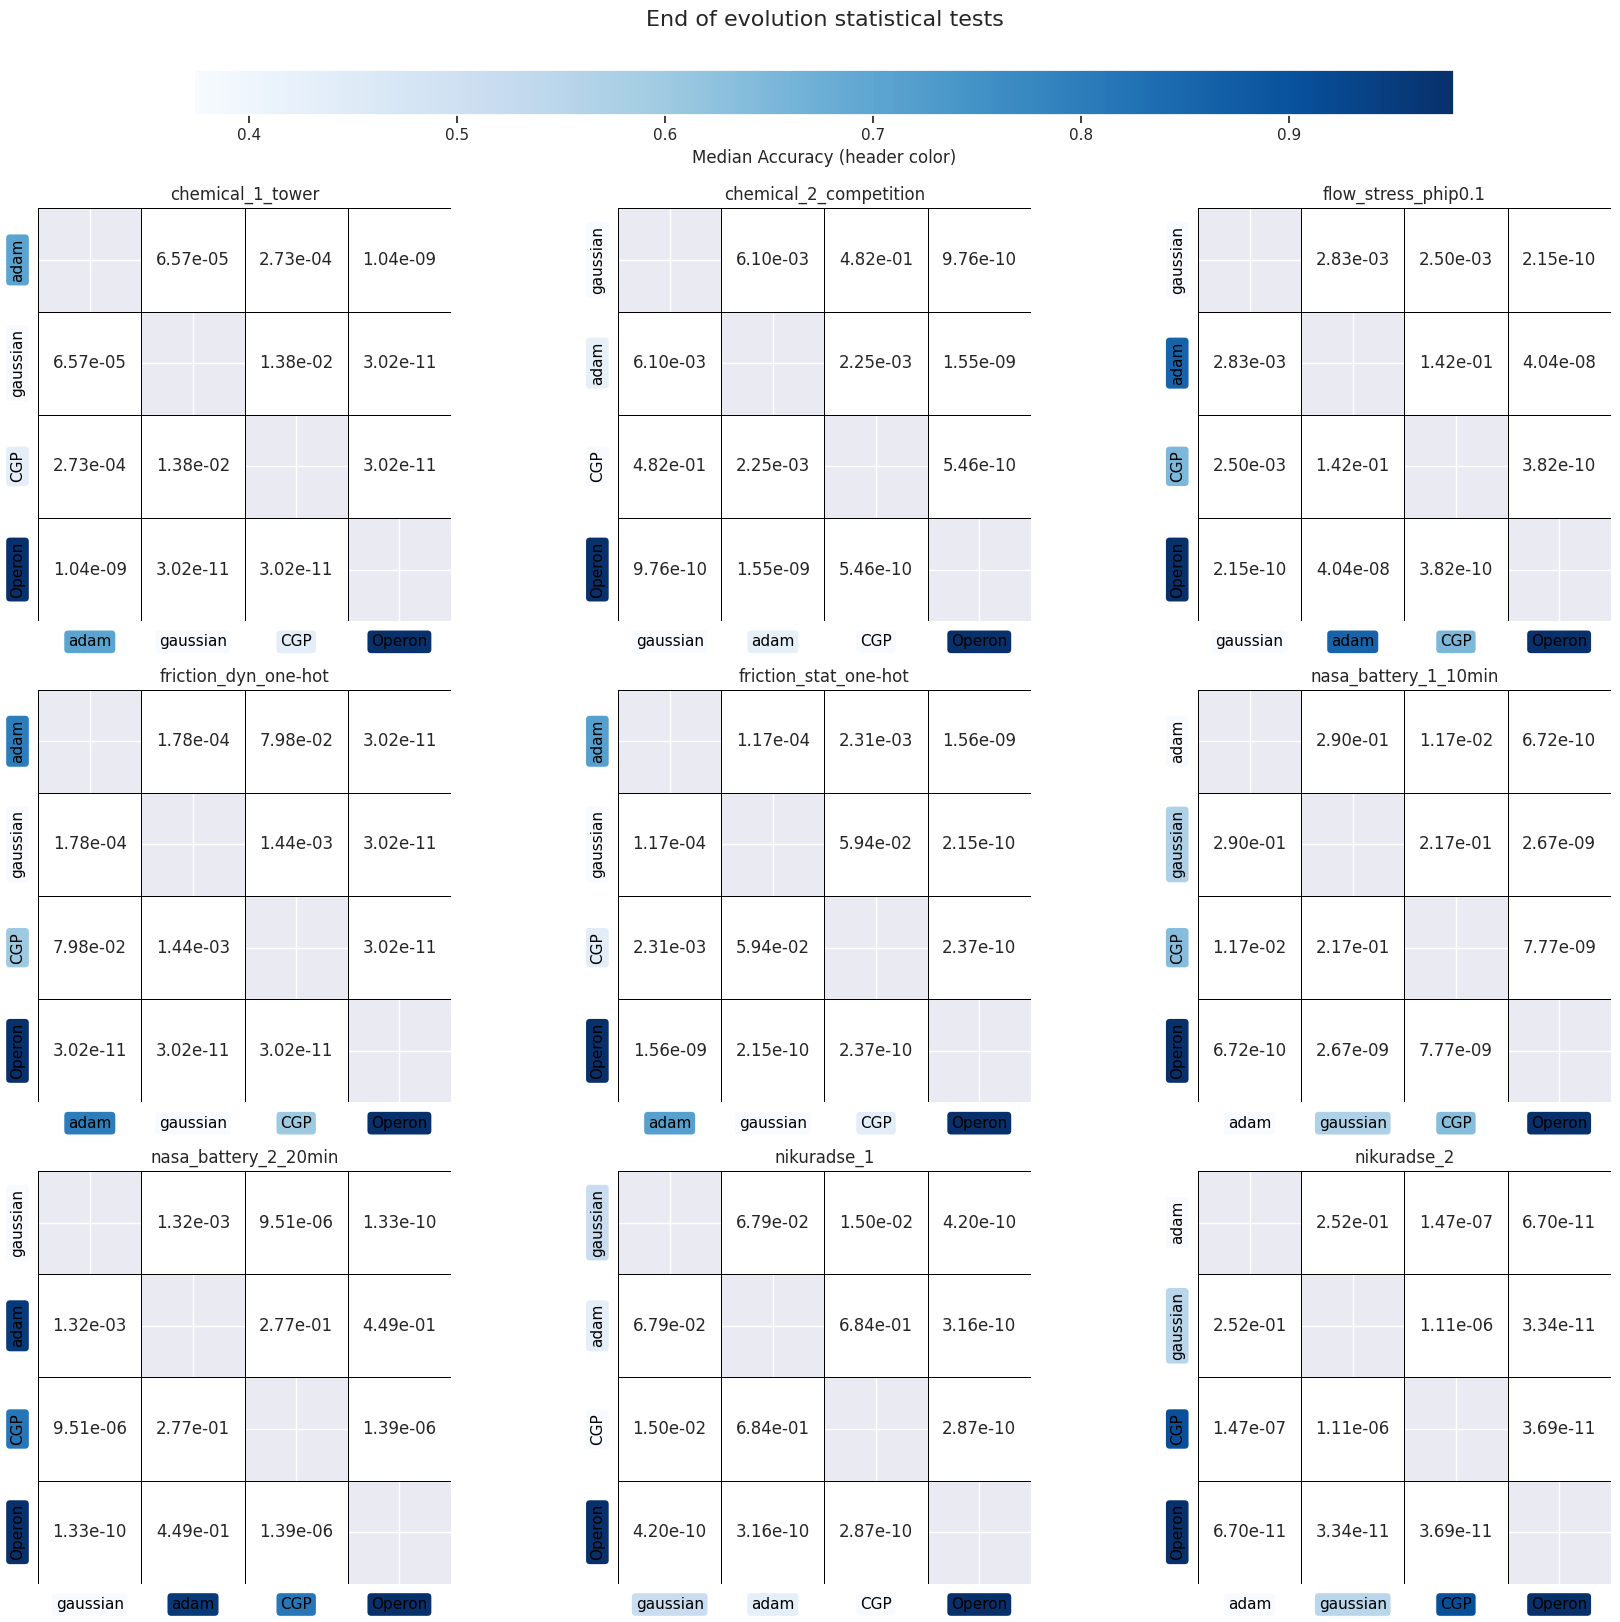

In [48]:
plot_all_problems_3x3(pval_tables_final, median_lookup_final, "End of evolution statistical tests")

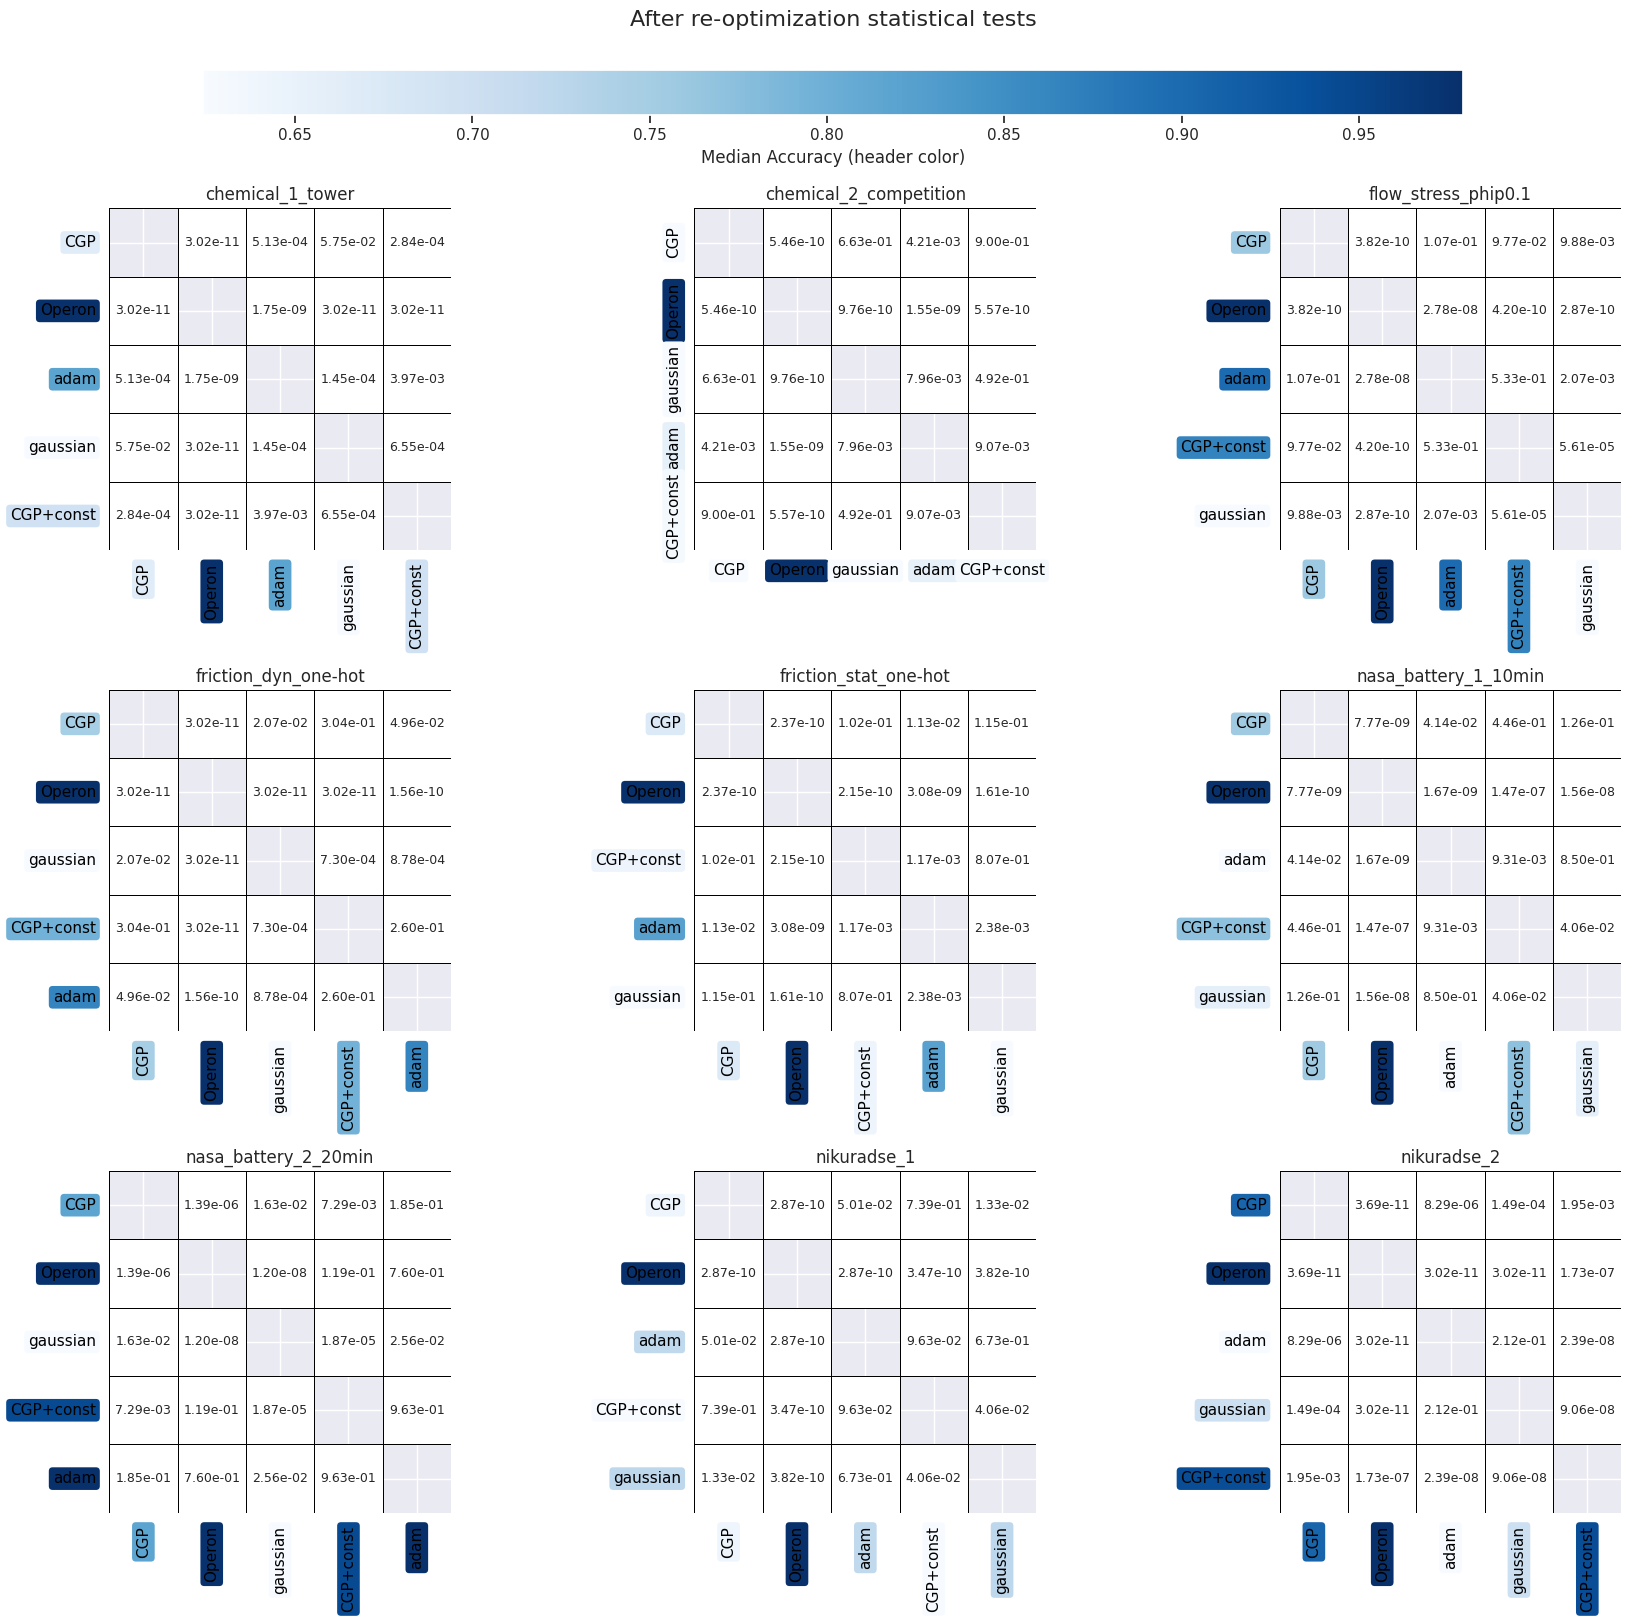

In [49]:
plot_all_problems_3x3(pval_tables_reopt, median_lookup_reopt, "After re-optimization statistical tests")